# Comparison of Classification Models
Michael Murrietta

3/17/2018

## Introduction
Classification is a fundamental task of many machine learning and statistical algorithms. An effort is given here to compare three different models on the task of classifying email messages as spam or ham using a single dataset. Since a subset of all available models is used for the task emphasis is made on the method of how to compare such models. Naive Bayes, Classification Trees from the CART algorithm, and random forests will be compared.

## Abstract
Problem from 10.8 
Compare Naive Bayes, CART, and one other algorithm.
A comparison means at least a 5 fold CV tuned model for each.
Which has the best precision
Which has the best recall
Which has the best accuracy
Which has the best F1
Based on those questions which model performs 'best' aka which would you implement if given the choice of 1 and only 1 
(no secret option D of ensemble them all).

## Methods
Naive Bayes was performed a la Nolan and Lang. Cart was also done. Random forests were done too.

Metrics used:
+ Precision
+ Recall (True Positive Rate)
+ Accuracy
+ F1 score
+ F2 score: I wanted to use this since it places more importance on negative cases. The rationale is that my preference as an email user would be to get all of my non-spam messages even at the cost of a few spam messages making into my inbox.

The functions that follow are due to Nolan and Lang from chapter 3 of their text (Nolan & Lang, 2015) and are used to read in and process the messages from a sub directory named `data`.

In [47]:
#read in functions and stopwords for naive Bayes
library(tm)
stopWords = stopwords()
cleanSW = tolower(gsub("[[:punct:]0-9[:blank:]]+", " ", stopWords))
SWords = unlist(strsplit(cleanSW, "[[:blank:]]+"))
SWords = SWords[ nchar(SWords) > 1 ]
stopWords = unique(SWords)

splitMessage = function(msg) {
  splitPoint = match("", msg)
  header = msg[1:(splitPoint-1)]
  body = msg[ -(1:splitPoint) ]
  return(list(header = header, body = body))
}

getBoundary = function(header) {
  boundaryIdx = grep("boundary=", header)
  boundary = gsub('"', "", header[boundaryIdx])
  gsub(".*boundary= *([^;]*);?.*", "\\1", boundary)
}

dropAttach = function(body, boundary){
  
  bString = paste("--", boundary, sep = "")
  bStringLocs = which(bString == body)
  
  if (length(bStringLocs) <= 1) return(body)
  
  eString = paste("--", boundary, "--", sep = "")
  eStringLoc = which(eString == body)
  if (length(eStringLoc) == 0) 
    return(body[ (bStringLocs[1] + 1) : (bStringLocs[2] - 1)])
  
  n = length(body)
  if (eStringLoc < n) 
     return( body[ c( (bStringLocs[1] + 1) : (bStringLocs[2] - 1), 
                    ( (eStringLoc + 1) : n )) ] )
  
  return( body[ (bStringLocs[1] + 1) : (bStringLocs[2] - 1) ])
}
    
cleanText =
function(msg)   {
  tolower(gsub("[[:punct:]0-9[:space:][:blank:]]+", " ", msg))
}

findMsgWords = 
function(msg, stopWords) {
 if(is.null(msg))
  return(character())

 words = unique(unlist(strsplit(cleanText(msg), "[[:blank:]\t]+")))
 
 # drop empty and 1 letter words
 words = words[ nchar(words) > 1]
 words = words[ !( words %in% stopWords) ]
 invisible(words)
}

processAllWords = function(dirName, stopWords)
{
       # read all files in the directory
  fileNames = list.files(dirName, full.names = TRUE)
       # drop files that are not email, i.e., cmds
  notEmail = grep("cmds$", fileNames)
  if ( length(notEmail) > 0) fileNames = fileNames[ - notEmail ]

  messages = lapply(fileNames, readLines, encoding = "latin1")
  
       # split header and body
  emailSplit = lapply(messages, splitMessage)
       # put body and header in own lists
  bodyList = lapply(emailSplit, function(msg) msg$body)
  headerList = lapply(emailSplit, function(msg) msg$header)
  rm(emailSplit)
  
       # determine which messages have attachments
  hasAttach = sapply(headerList, function(header) {
    CTloc = grep("Content-Type", header)
    if (length(CTloc) == 0) return(0)
    multi = grep("multi", tolower(header[CTloc])) 
    if (length(multi) == 0) return(0)
    multi
  })
  
  hasAttach = which(hasAttach > 0)
  
       # find boundary strings for messages with attachments
  boundaries = sapply(headerList[hasAttach], getBoundary)
  
       # drop attachments from message body
  bodyList[hasAttach] = mapply(dropAttach, bodyList[hasAttach], 
                               boundaries, SIMPLIFY = FALSE)
  
       # extract words from body
  msgWordsList = lapply(bodyList, findMsgWords, stopWords)
  
  invisible(msgWordsList)
}

In [48]:
#some other constants to allow us to use the above functions when processing messages
#for naive Bayes
spamPath = "./data"
dirNames = list.files(path = paste(spamPath, "messages",
                      sep = .Platform$file.sep))
fullDirNames = paste(spamPath, "messages", dirNames, 
                     sep = .Platform$file.sep)

In [49]:
#now read in and process the raw messages using the above functions
msgWordsList = lapply(fullDirNames, processAllWords, 
                      stopWords = stopWords) 

#get number of messages in each directory
numMsgs = sapply(msgWordsList, length)
print(numMsgs)

Warning message in FUN(X[[i]], ...):
"incomplete final line found on './data/messages/hard_ham/00228.0eaef7857bbbf3ebf5edbbdae2b30493'"Warning message in FUN(X[[i]], ...):
"incomplete final line found on './data/messages/hard_ham/0231.7c6cc716ce3f3bfad7130dd3c8d7b072'"Warning message in FUN(X[[i]], ...):
"incomplete final line found on './data/messages/hard_ham/0250.7c6cc716ce3f3bfad7130dd3c8d7b072'"Warning message in FUN(X[[i]], ...):
"incomplete final line found on './data/messages/spam/00136.faa39d8e816c70f23b4bb8758d8a74f0'"Warning message in FUN(X[[i]], ...):
"incomplete final line found on './data/messages/spam/0143.260a940290dcb61f9327b224a368d4af'"

[1] 5051 1400  500 1000 1397


At this point we have `msgWordsList` which is a list of 5 sub lists corresponding to the directories from which they came. The directories are: `easy_ham`, `easy_ham_2`, `hard_ham`, `spam`, and `spam_2`. Each sub list is a list of processed messages from the respective directory.

In [50]:
#create logical labels for each message based on which folder they are in:
#the first 3 are ham the last 2 are spam
isSpam = rep(c(FALSE, FALSE, FALSE, TRUE, TRUE), numMsgs)

#flatten into a single list of msgs
msgWordsList = unlist(msgWordsList, recursive = FALSE)

The following functions are again from the text (Nolan & Lang, 2015) and are used to train a model given some training messages (`computeFreqs`) and then compute the log likelihood ratio for a given message `computeMsgLLR`.

In [51]:
computeFreqs =
function(wordsList, spam, bow = unique(unlist(wordsList)))
{
   # create a matrix for spam, ham, and log odds
  wordTable = matrix(0.5, nrow = 4, ncol = length(bow), 
                     dimnames = list(c("spam", "ham", 
                                        "presentLogOdds", 
                                        "absentLogOdds"),  bow))

   # For each spam message, add 1 to counts for words in message
  counts.spam = table(unlist(lapply(wordsList[spam], unique)))
  wordTable["spam", names(counts.spam)] = counts.spam + .5

   # Similarly for ham messages
  counts.ham = table(unlist(lapply(wordsList[!spam], unique)))  
  wordTable["ham", names(counts.ham)] = counts.ham + .5  


   # Find the total number of spam and ham
  numSpam = sum(spam)
  numHam = length(spam) - numSpam

   # Prob(word|spam) and Prob(word | ham)
  wordTable["spam", ] = wordTable["spam", ]/(numSpam + .5)
  wordTable["ham", ] = wordTable["ham", ]/(numHam + .5)
  
   # log odds
  wordTable["presentLogOdds", ] = 
     log(wordTable["spam",]) - log(wordTable["ham", ])
  wordTable["absentLogOdds", ] = 
     log((1 - wordTable["spam", ])) - log((1 -wordTable["ham", ]))

  invisible(wordTable)
}

In [52]:
#compute LLR of a processed message
computeMsgLLR = function(words, freqTable) 
{
       # Discards words not in training data.
  words = words[!is.na(match(words, colnames(freqTable)))]

       # Find which words are present
  present = colnames(freqTable) %in% words

  sum(freqTable["presentLogOdds", present]) +
    sum(freqTable["absentLogOdds", !present])
}

These functions are adapted from the `typeIErrorRate` function given by Nolan and Lang, these calculate all rates from the 2 x 2 confusion matrix associated with threshold `tau`, the log likelihood ratios `llrVals`, and the labels of spam or not-spam `spam`.

### Testing Naive Bayes
Here we test the naive Bayes method as implemented in the Nolan and Lang's text (Nolan & Lang, 2015) using 10 fold cross validation. Most of the code below is taken from the text but was modified to easily calculate the metrics of interest as well as to produce the ROC plot.

The work in chapter 3 of the text suggests that -35 is a choice for threshold that will produce a false positive rate of 0.01 and a false negative rate of about 0.06. The way this was arrived at was by pooling together the out-of-fold false positive/negative rates and then selecting the threshold that accounted for the best false negative rate after subsetting for thresholds that produced a false positive rate of 0.01. This was in effort to select the best threshold for the model independent of the training set used.

In this case the threshold of -35 is retained where log likelihood ratios less than or equal to -35 are considered not spam and those with log likelihood ratios greater than -35 are considered to be spam.

In [53]:
#calculate confusion matrix proportions and some other measures of error
#adapted from previous definition but now for a generic vector of predictions and true labels (no threshold needed)
falsePosRate = 
function(yhat, y)
{
  sum(yhat & !y)/sum(!y) #sum all false positives divide by sum of all actual positives
}
falseNegRate = 
function(yhat, y)
{
  sum(!yhat & y)/sum(y) #sum all false positives divide by sum of all actual positives
}
truePosRate = 
function(yhat, y)
{
  sum(yhat & y)/sum(y)
}
trueNegRate = 
function(yhat, y)
{
  sum(!yhat & !y)/sum(!y) #sum all non-spam that were actually negative, divide by all negatives
}
#precision is number of true positives divided by number of all predicted positives
precision = function(yhat, y)
{
  sum(yhat & y)/sum(yhat)
}
#recall is number of true positives divided by number of all actual positives
#which is just the true positive rate for which we already have a function to use

#f1 score is the harmonic mean of precision and recall
f1score = function(yhat, y)
{
  prec = precision(yhat, y)
  rec = truePosRate(yhat, y)
  (2*prec*rec)/(prec + rec)
}

accuracy = function(yhat, y)
{
  (sum(yhat & y) + sum(!yhat & !y))/length(y)
}

In [54]:
#now collect FPR and TPR for each fold using the suggested threshold from the previous analysis
k = 10 #set k
numTrain = length(msgWordsList) #get number of training observations
partK = sample(numTrain) #randomly sample digits between 1 and numTrain
tot = k * floor(numTrain/k) #set the total number of observations we'll use in all k folds, ensures even amounts
partK = matrix(partK[1:tot], ncol = k) #matrix using the the first tot items in the vector version of partK

testFoldOdds = NULL #a blank vector: we'll append the Odds vectors produced for each test fold
for (i in 1:k) {
  foldIdx = partK[ , i] #use column i in partK to test, use the rest for training
  trainTabFold = computeFreqs(msgWordsList[-foldIdx], isSpam[-foldIdx])
  testFoldOdds = c(testFoldOdds, 
               sapply(msgWordsList[ foldIdx ], computeMsgLLR, trainTabFold))
}

testFoldSpam = NULL #blank vector that gets the labels for spam or not spam of each test fold
for (i in 1:k) {
  foldIdx = partK[ , i]
  testFoldSpam = c(testFoldSpam, isSpam[foldIdx])
}

In [55]:
#apply our threshold to the odds
testFoldPred = testFoldOdds > -35
#expand the predictions and actual labels into matrices, one column for each set of out-of-sample folds
testFoldPred = matrix(testFoldPred, ncol=k)
testFoldSpam = matrix(testFoldSpam, ncol=k)

In [56]:
#calculate our metrics for naive Bayes
cvratesNBbow = cbind("fold" = 1:k,
              "method" = rep("naive_bayes_bow",k),
              "tpr" = unlist(lapply(1:k, function(i) truePosRate(testFoldPred[,i], testFoldSpam[,i]))), 
              "fpr" = unlist(lapply(1:k, function(i) falsePosRate(testFoldPred[,i], testFoldSpam[,i]))),
              "prec" = unlist(lapply(1:k, function(i) precision(testFoldPred[,i], testFoldSpam[,i]))),
              "f1" = unlist(lapply(1:k, function(i) f1score(testFoldPred[,i], testFoldSpam[,i]))),
              "acc" = unlist(lapply(1:k, function(i) accuracy(testFoldPred[,i], testFoldSpam[,i]))))
cvratesNBbow

fold,method,tpr,fpr,prec,f1,acc
1,naive_bayes_bow,0.960869565217391,0.00852272727272727,0.973568281938326,0.967177242888403,0.983940042826552
2,naive_bayes_bow,0.956175298804781,0.00878477306002928,0.975609756097561,0.96579476861167,0.981798715203426
3,naive_bayes_bow,0.960352422907489,0.0099009900990099,0.968888888888889,0.964601769911505,0.982869379014989
4,naive_bayes_bow,0.943127962085308,0.00276625172890733,0.990049751243781,0.966019417475728,0.985010706638116
5,naive_bayes_bow,0.962655601659751,0.00577200577200577,0.983050847457627,0.972746331236897,0.986081370449679
6,naive_bayes_bow,0.975903614457831,0.00875912408759124,0.975903614457831,0.975903614457831,0.987152034261242
7,naive_bayes_bow,0.956,0.0087719298245614,0.975510204081633,0.965656565656566,0.981798715203426
8,naive_bayes_bow,0.936254980079681,0.00732064421669107,0.979166666666667,0.957230142566191,0.977516059957173
9,naive_bayes_bow,0.956862745098039,0.00441826215022091,0.987854251012146,0.97211155378486,0.985010706638116
10,naive_bayes_bow,0.952380952380952,0.0113798008534851,0.964912280701754,0.958605664488017,0.9796573875803


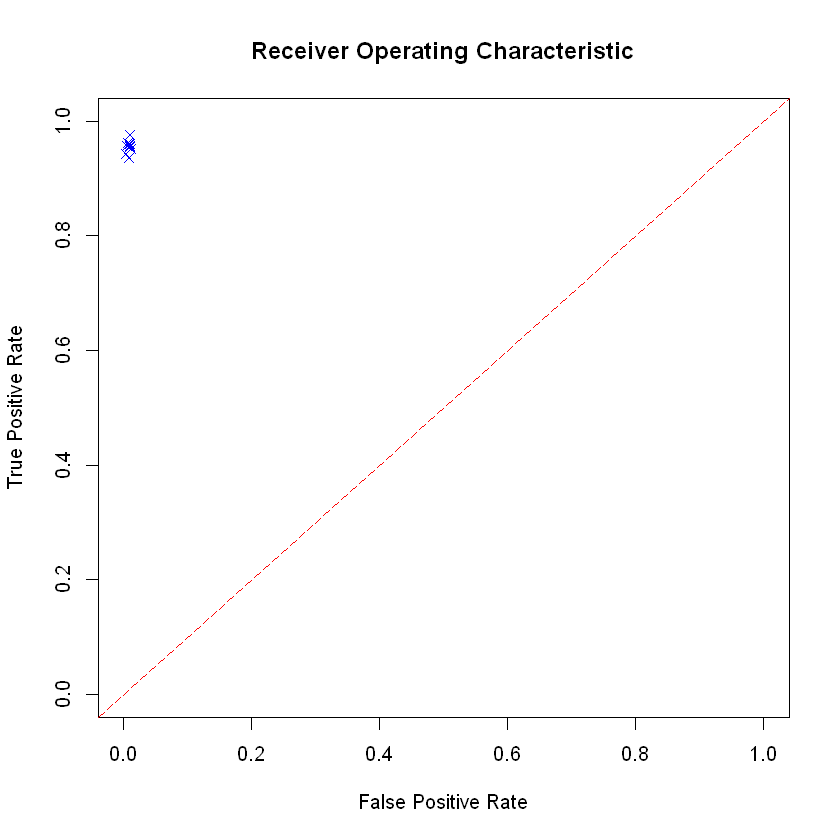

In [57]:
plot(cvratesNBbow[,4], cvratesNBbow[,3], ylim=c(0,1), xlim=c(0,1), pch=4, col="blue",
     xlab="False Positive Rate", ylab="True Positive Rate", main="Receiver Operating Characteristic")
abline(0, 1, lty=5, col="red")

#### The other models
The preceding work was not just a naive Bayes classifier but a naive Bayes classifier using a bag-of-words framework. While it is not impossible to use the bag-of-words framework for the other models it will require some work to get the data into a usable format using bag-of-words. The following section will instead import the derived dataset as described in Nolan and Lang's text and proceed to use `naive_bayes`, `rpart`, and `random_forest` classifiers from their respective packages.

In [58]:
#load the data
#this is for the CART part later
load("spamAssassinDerivedDF.rda")
print(dim(emailDF))

[1] 9348   30


In [59]:
#some setup for naivebayes
library(naivebayes)

In [60]:
#some setup for rpart, this is from Nolan and Lang's code
library(rpart)

setupRpart = function(data) {
  logicalVars = which(sapply(data, is.logical))
  facVars = lapply(data[ , logicalVars], 
                   function(x) {
                      x = as.factor(x)
                      levels(x) = c("F", "T")
                      x
                   })
  cbind(facVars, data[ , - logicalVars])
}

emailDFrp = setupRpart(emailDF)

In [61]:
#some setup for random forest
#taken from Professor Slater's notebook
#tried using randomForest on emailDF and quickly realized there was something wrong
library(randomForest)
setupRnum = function(data) {
  logicalVars = which(sapply(data, is.logical))
  facVars = lapply(data[ , logicalVars], 
                   function(x) {
                      x = as.numeric(x)
                   })
  cbind(facVars, data[ , - logicalVars])
}

emailDFnum = setupRnum(emailDF)

#convert any na's to 0
emailDFnum[is.na(emailDFnum)] <- 0

In [62]:
#set the seed for reproducibility
#i'm not using caret, obviously. cv doesn't seem too unmanageable at this time
set.seed(418910)

#setup our folds, we'll use the same folds for every model we try
k = 10 #set k
numTrain = dim(emailDF)[1] #get number of training observations
partK = sample(numTrain) #randomly sample digits between 1 and numTrain
tot = k * floor(numTrain/k) #set the total number of observations we'll use in all k folds, ensures even amounts
partK = matrix(partK[1:tot], ncol = k) #matrix using the the first tot items in the vector version of partK

In [63]:
#checking if the proportion of spam in our folds is similar to the actual
lapply(1:k, function(i) sum(emailDF[partK[,i],"isSpam"])/(dim(partK)[1]))

[[1]]
[1] 0.2773019

[[2]]
[1] 0.2826552

[[3]]
[1] 0.2473233

[[4]]
[1] 0.2655246

[[5]]
[1] 0.2591006

[[6]]
[1] 0.2430407

[[7]]
[1] 0.2462527

[[8]]
[1] 0.245182

[[9]]
[1] 0.2430407

[[10]]
[1] 0.2537473

In [64]:
#running cv for naive bayes model from naivebayes package
testFoldPredNB = NULL
testFoldPredRP = NULL
testFoldPredRF = NULL
testFoldSpam = NULL
for (i in 1:k) {
  foldIdx = partK[ , i] #isolate indices for testing
  nb <- naive_bayes(isSpam ~ ., data=emailDF[-foldIdx,]) #train with all data except for the test fold 
  rp <- rpart(isSpam ~ ., data = emailDFrp[-foldIdx,], method = "class")
  rf <- randomForest(as.factor(isSpam) ~ ., data=emailDFnum[-foldIdx,], ntree=100)
  testFoldPredNB = c(testFoldPredNB, as.logical(predict(nb, newdata=emailDF[foldIdx,])))
  testFoldPredRP = c(testFoldPredRP, apply(predict(rp, newdata=emailDFrp[foldIdx,]),1, 
                                           function(x) which.max(x)-1) == 1)
  testFoldPredRF = c(testFoldPredRF, (predict(rf, newdata=emailDFnum[foldIdx,]) == 1))
  testFoldSpam = c(testFoldSpam, emailDF[foldIdx,'isSpam'])
}

#expand the odds and actual labels into matrices, one column for each set of out-of-sample folds
testFoldPredNB = matrix(testFoldPredNB, ncol=k)
testFoldPredRP = matrix(testFoldPredRP, ncol=k)
testFoldPredRF = matrix(testFoldPredRF, ncol=k)
testFoldSpam = matrix(testFoldSpam, ncol=k)

In [117]:
#now we can calculate all of our metrics for naivebayes and place it in nice matrix format
nbcvrates = cbind("fold" = 1:k,
              "method" = rep("naive_bayes",k),
              "tpr" = unlist(lapply(1:k, function(i) truePosRate(testFoldPredNB[,i], testFoldSpam[,i]))), 
              "fpr" = unlist(lapply(1:k, function(i) falsePosRate(testFoldPredNB[,i], testFoldSpam[,i]))),
              "prec" = unlist(lapply(1:k, function(i) precision(testFoldPredNB[,i], testFoldSpam[,i]))),
              "f1" = unlist(lapply(1:k, function(i) f1score(testFoldPredNB[,i], testFoldSpam[,i]))),
              "acc" = unlist(lapply(1:k, function(i) accuracy(testFoldPredNB[,i], testFoldSpam[,i]))))
rpcvrates = cbind("fold" = 1:k,
              "method" = rep("rpart",k),
              "tpr" = unlist(lapply(1:k, function(i) truePosRate(testFoldPredRP[,i], testFoldSpam[,i]))), 
              "fpr" = unlist(lapply(1:k, function(i) falsePosRate(testFoldPredRP[,i], testFoldSpam[,i]))),
              "prec" = unlist(lapply(1:k, function(i) precision(testFoldPredRP[,i], testFoldSpam[,i]))),
              "f1" = unlist(lapply(1:k, function(i) f1score(testFoldPredRP[,i], testFoldSpam[,i]))),
              "acc" = unlist(lapply(1:k, function(i) accuracy(testFoldPredRP[,i], testFoldSpam[,i]))))
rfcvrates = cbind("fold" = 1:k,
              "method" = rep("randomForest",k),
              "tpr" = unlist(lapply(1:k, function(i) truePosRate(testFoldPredRF[,i], testFoldSpam[,i]))), 
              "fpr" = unlist(lapply(1:k, function(i) falsePosRate(testFoldPredRF[,i], testFoldSpam[,i]))),
              "prec" = unlist(lapply(1:k, function(i) precision(testFoldPredRF[,i], testFoldSpam[,i]))),
              "f1" = unlist(lapply(1:k, function(i) f1score(testFoldPredRF[,i], testFoldSpam[,i]))),
              "acc" = unlist(lapply(1:k, function(i) accuracy(testFoldPredRF[,i], testFoldSpam[,i]))))
cvrates = rbind(cvratesNBbow, nbcvrates, rpcvrates, rfcvrates)

In [118]:
#this will put "method" as the first column
cvrates = as.matrix(merge(cvrates, cbind("method"=unique(cvrates[,2]),"num_method"=c(1,2,3,4))))

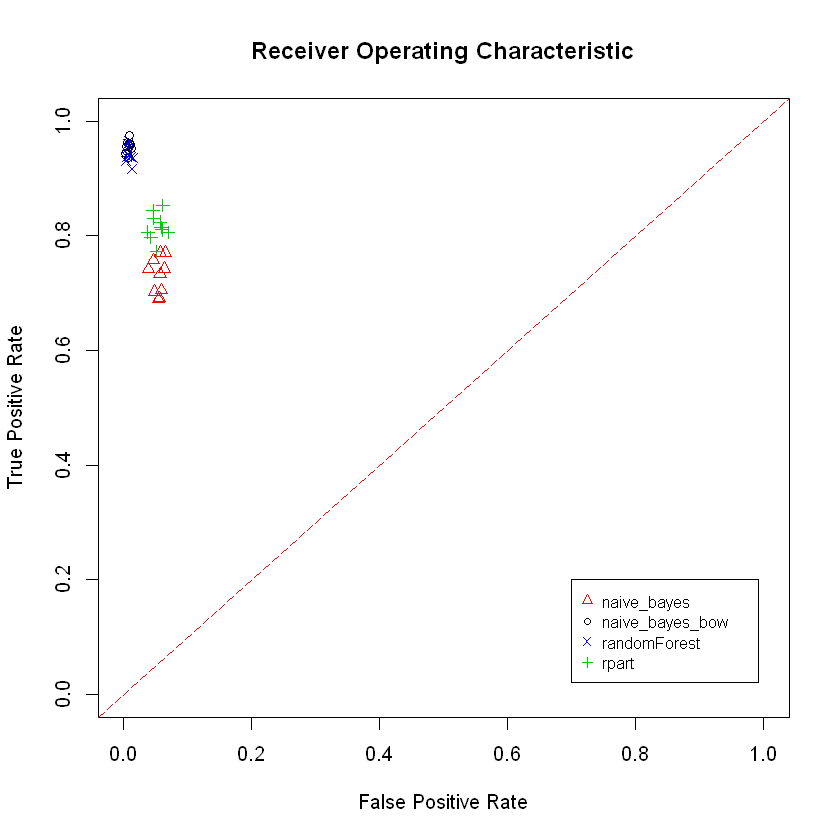

In [134]:
plot(cvrates[,4], cvrates[,3], ylim=c(0,1), xlim=c(0,1), pch=as.integer(cvrates[,8]), col=cvrates[,8],
     xlab="False Positive Rate", ylab="True Positive Rate", main="Receiver Operating Characteristic")
abline(0, 1, lty=5, col="red")
legend(0.7, 0.2, legend=unique(cvrates[,1]),
       col=as.integer(unique(cvrates[,8])), pch=as.integer(unique(cvrates[,8])), cex=0.8)
# plot(cvrates[,4], cvrates[,3], pch=as.integer(cvrates[,8]), col=cvrates[,8],
#      xlab="False Positive Rate", ylab="True Positive Rate", main="Receiver Operating Characteristic")
# legend(0.05, 0.97, legend=unique(cvrates[,1]),
#        col=as.integer(unique(cvrates[,8])), pch=as.integer(unique(cvrates[,8])), cex=0.8)

So using naive Bayes outside of the bag-of-words framework is not so great.

## Results


## Conclusion


## References